In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/iceberg-classifier-data/sample_submission.csv
/kaggle/input/iceberg-classifier-data/train.json
/kaggle/input/iceberg-classifier-data/test.json


In [2]:
import pandas as pd
!pip install py7zr
import py7zr
import os
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras import Sequential
from keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dense
from keras.layers import Dense, Dropout, Flatten, Input
from tensorflow.keras.optimizers import SGD,Adam

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.9/67.9 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.1/93.1 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 32.3 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.9/138.9 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 413.8/413.8 kB 18.4 MB/s eta 0:00:00


In [7]:
train = pd.read_json('/kaggle/input/iceberg-classifier-data/train.json')
test = pd.read_json('/kaggle/input/iceberg-classifier-data/test.json')
train.head()

,id,band_1,band_2,inc_angle,is_iceberg
0,dfd5f913,"[-27.878360999999998, -27.15416, -28.668615, -...","[-27.154118, -29.537888, -31.0306, -32.190483,...",43.9239,0
1,e25388fd,"[-12.242375, -14.920304999999999, -14.920363, ...","[-31.506321, -27.984554, -26.645678, -23.76760...",38.1562,0
2,58b2aaa0,"[-24.603676, -24.603714, -24.871029, -23.15277...","[-24.870956, -24.092632, -20.653963, -19.41104...",45.2859,1
3,4cfc3a18,"[-22.454607, -23.082819, -23.998013, -23.99805...","[-27.889421, -27.519794, -27.165262, -29.10350...",43.8306,0
4,271f93f4,"[-26.006956, -23.164886, -23.164886, -26.89116...","[-27.206915, -30.259186, -30.259186, -23.16495...",35.6256,0


In [14]:
import numpy as np
def get_scaled_imgs(df):
    imgs = []
    label =[]

    for i, row in df.iterrows():
        #make 75x75 image
        band_1 = np.array(row['band_1']).reshape(75, 75)
        band_2 = np.array(row['band_2']).reshape(75, 75)
        band_3 = band_1 + band_2 # plus since log(x*y) = log(x) + log(y)

        # Rescale
        a = (band_1 - band_1.mean()) / (band_1.max() - band_1.min())
        b = (band_2 - band_2.mean()) / (band_2.max() - band_2.min())
        c = (band_3 - band_3.mean()) / (band_3.max() - band_3.min())
        imgs.append(np.dstack((a, b, c)))
    return np.array(imgs)
                    

In [15]:
data=get_scaled_imgs(train)
target = np.array(train['is_iceberg'])

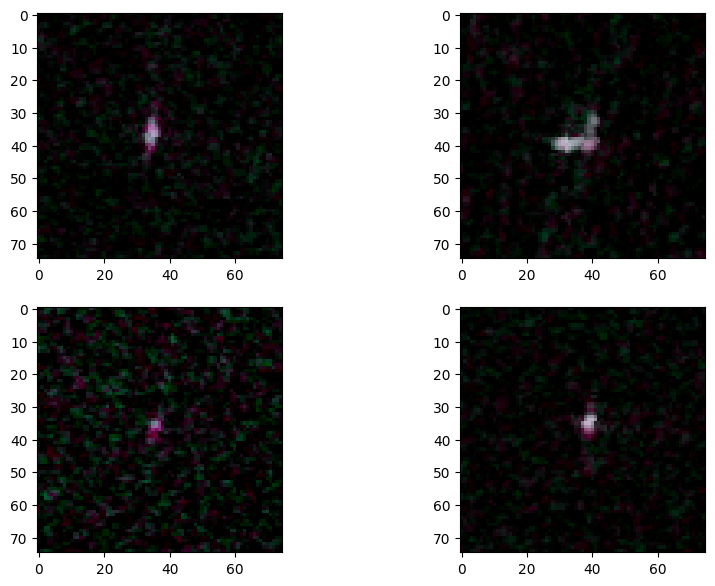

In [16]:
# create figure
fig = plt.figure(figsize=(10, 7))
rows = 2
columns = 2

for i in range(4):
# Adds a subplot at the 1st position
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(data[i])
  

In [17]:
x=data
y=train['is_iceberg']

In [18]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(data,target,test_size=0.2,random_state=1)

In [19]:
input_size = (75, 75, 3)
model=Sequential()
model.add(Input(shape=input_size))
model.add(Conv2D(32,kernel_size=(3,3),padding='same',activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(64,kernel_size=(3,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Flatten())
model.add(Dense(128))
model.add(Dense(36, activation='softmax')) 
model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [20]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 75, 75, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 37, 37, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 35, 35, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 17, 17, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 18496)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     2,367,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 36)             │         4,644 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,391,652 (9.12 MB)

 Trainable params: 2,391,652 (9.12 MB)

 Non-trainable params: 0 (0.00 B)

In [21]:
history=model.fit(x_train, y_train, batch_size=64, epochs=10, validation_data=(x_test, y_test))

Epoch 1/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 8s 281ms/step - accuracy: 0.4635 - loss: 1.2866 - val_accuracy: 0.6449 - val_loss: 0.6117
Epoch 2/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 6s 266ms/step - accuracy: 0.7442 - loss: 0.5237 - val_accuracy: 0.7726 - val_loss: 0.4755
Epoch 3/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 257ms/step - accuracy: 0.8042 - loss: 0.4205 - val_accuracy: 0.8442 - val_loss: 0.3967
Epoch 4/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 10s 259ms/step - accuracy: 0.8505 - loss: 0.3375 - val_accuracy: 0.8380 - val_loss: 0.3708
Epoch 5/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 10s 260ms/step - accuracy: 0.9215 - loss: 0.2456 - val_accuracy: 0.8380 - val_loss: 0.3677
Epoch 6/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 10s 258ms/step - accuracy: 0.9551 - loss: 0.1597 - val_accuracy: 0.8411 - val_loss: 0.3611
Epoch 7/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 10s 266ms/step - accuracy: 0.9609 - loss: 0.1365 - val_accuracy: 0.6542 - val_loss: 1.0551
Epoch 8/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 258ms/step - accuracy: 0.8878 - loss: 0.2423 - val_accuracy

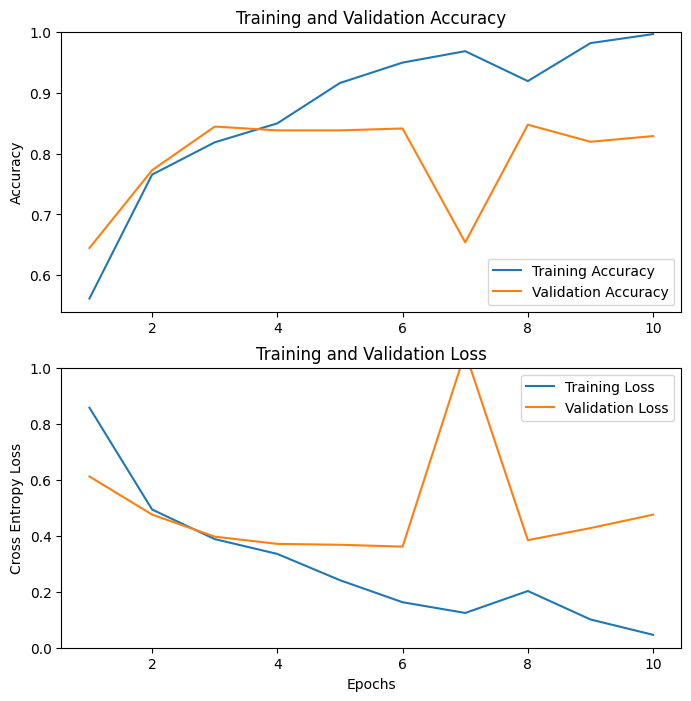

In [22]:
import matplotlib.pyplot as plt

# Retrieve the training and validation metrics from the history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Define the range of epochs
epochs_range = range(1, len(acc) + 1)

# Plot the training and validation accuracy
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()), 1])
plt.title('Training and Validation Accuracy')

# Plot the training and validation loss
plt.subplot(2, 1, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy Loss')
plt.ylim([0, 1.0])
plt.xlabel('Epochs')
plt.title('Training and Validation Loss')

plt.show()